# Modelling

## Packages

In [1]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import winsound
import datetime as dt

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, OneHotEncoder, normalize
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
import joblib

import xgboost

import tensorflow
from tensorflow.keras import layers
from tensorflow.keras import utils
from tensorflow.keras.models import load_model

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.losses import CategoricalCrossentropy, BinaryCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy, BinaryAccuracy
#from tensorflow.nn import relu, softmax

from imblearn.over_sampling import SMOTE

from matplotlib import pyplot as plt

print(f" Found and Using {len(tensorflow.config.experimental.list_physical_devices('GPU'))} GPU")

 Found and Using 1 GPU


## Functions

In [2]:
def scale_x_encode_y(x, y):

    scaler_obj = StandardScaler()
    #scaler_obj = MinMaxScaler()
    scaler_obj.fit(x.values)
    x_scaled = scaler_obj.transform(x.values)
    #x_scaled = x.values
    
    encoder = LabelEncoder()
    encoder.fit(y)
    y_encoded = encoder.transform(y)
    y_encoded = utils.to_categorical(y_encoded)
    
    y_map = dict(zip(encoder.transform(encoder.classes_),encoder.classes_))
 
    return(x_scaled, y_encoded, y_map, scaler_obj)


def smote_data(x, y):
    oversample = SMOTE()
    smote_x, smote_y = oversample.fit_resample(x, y)
    return(smote_x, smote_y)


def data_prep(df, apply_smote = False):
    x = df.loc[:, df.columns != target_col]
    y = df[target_col]

    if apply_smote:
        x, y = smote_data(x, y)

    print(f'Record count : {len(y)}')
    print('--------------------------')
    print(y.value_counts())
    print('--------------------------')
    print(y.value_counts(normalize=True))
    
    x_scaled, y_encoded, y_map, scaler_obj = scale_x_encode_y(x, y)
    pd.DataFrame(x_scaled).head()
    
    return(x_scaled, y_encoded, y_map, scaler_obj)

## Read Data

In [3]:
#remove_cols = ['tick_avg', 'sema', 'ssma', 'lema', 'lsma', 'max_tick', 'min_tick', 'small_sema_slope', 'long_sema_slope']
remove_cols = ['tick_avg', 'sema', 'ssma', 'lema', 'lsma', 'max_tick', 'min_tick', 'rs']

In [4]:
train_files = ['2013', '2014', '2015', '2016', '2017', '2018', '2019']
#train_files = ['2019']
df = pd.DataFrame()

for i, train_file in enumerate(train_files): 
    
    train_data = 'data/yearly_tick_data/tab_'+ train_file +'.csv'
    df1 = pd.read_csv(train_data)
    df = df.append(df1)
    df = df.reset_index(drop=True)

df.drop(remove_cols, axis=1, inplace=True)
print(len(df))
df.head(5)

605336


,spread_avg,tick_sd,sema_diff,lema_diff,diff,avg_gain,avg_loss,rsi,ssma_diff,lsma_diff,sma_diff,max_gap,min_gap,small_sema_slope,long_sema_slope,ema_diff,direction
0,0.000135,0.000049,-0.000109,-0.000083,-0.000223,0.000152,0.000203,42.836177,-0.000051,-0.000016,-0.000005,0.000541,0.000000,-0.855861,35.661365,-0.000013,same
1,0.000135,0.000093,-0.000018,-0.000017,0.000148,0.000163,0.000203,44.485171,-0.000028,-0.000018,-0.000016,0.000393,-0.000148,-56.577728,-47.500625,-0.000013,same
2,0.000126,0.000131,0.000041,0.000022,0.000109,0.000129,0.000203,38.815630,0.000038,-0.000005,0.000028,0.000284,-0.000257,-73.671389,-48.748686,0.000006,increase
3,0.000144,0.000373,0.000272,0.000256,0.000700,0.000138,0.000203,40.414274,0.000083,0.000148,-0.000037,0.000000,-0.000957,75.933800,57.642639,0.000022,increase
4,0.000127,0.000158,0.000424,0.000357,0.000590,0.000180,0.000102,63.835333,0.000265,0.000168,0.000060,0.000000,-0.001547,86.738283,84.986027,0.000090,increase




train_file = '2019'
train_data = 'data/yearly_tick_data/tab_'+ train_file +'.csv'
df = pd.read_csv(train_data)

#train_file = '2020'
#train_data = 'data/yearly_tick_data/tab_'+ train_file +'.csv'
#df1 = pd.read_csv(train_data)
#df = df.append(df1)
#df = df.reset_index(drop=True)

df.drop(remove_cols, axis=1, inplace=True)
df.head(5)

## -----------------------------------

In [5]:
%%time
target_col = 'direction'
x = df.loc[:, df.columns != target_col]
y = df[target_col]
train_x, valid_x, train_y, valid_y = train_test_split(x, y,train_size = 0.8,random_state = 1)

Wall time: 159 ms


alg = xgboost.XGBClassifier(tree_method='gpu_hist', gpu_id=0)
clf_xg = GridSearchCV(alg,{'max_depth': [2,4,6],
                    'n_estimators': [50,100,200]}, 
                    verbose=2, 
                    scoring='neg_log_loss',
                     n_jobs = -1)


clf_xg.fit(train_x, train_y)

print(clf_xg.best_score_, clf_xg.best_params_)

joblib.dump(clf_xg, 'data/model/model_xg.pkl') 

predictions = clf_xg.predict(valid_x)
rounded_valid_y = np.argmax(valid_y, axis = -1)
print(classification_report(valid_y, predictions))

In [6]:
%%time
clf_xg = xgboost.XGBClassifier(tree_method='gpu_hist', gpu_id=0)

clf_xg.fit(train_x, train_y)
joblib.dump(clf_xg, 'data/model/model_xg.pkl') 

predictions = clf_xg.predict(valid_x)
rounded_valid_y = np.argmax(valid_y, axis = -1)
print(classification_report(valid_y, predictions))

[20:27:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

    decrease       0.69      0.54      0.60     23319
    increase       0.69      0.52      0.59     22874
        same       0.75      0.86      0.81     74875

    accuracy                           0.74    121068
   macro avg       0.71      0.64      0.67    121068
weighted avg       0.73      0.74      0.73    121068

Wall time: 11.4 s


clf_xg.get_xgb_params()

## -----------------------------------

<AxesSubplot:>

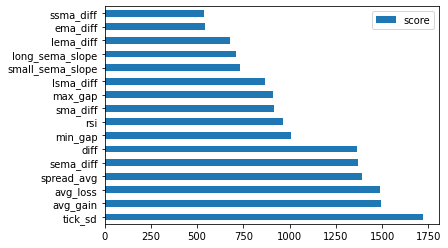

In [7]:
feature_important = clf_xg.get_booster().get_score(importance_type='weight')
keys = list(feature_important.keys())
values = list(feature_important.values())

data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
data.plot(kind='barh')

              precision    recall  f1-score   support

    decrease       0.71      0.53      0.60     18493
    increase       0.71      0.51      0.59     18150
        same       0.71      0.85      0.77     50174

    accuracy                           0.71     86817
   macro avg       0.71      0.63      0.66     86817
weighted avg       0.71      0.71      0.70     86817

Wall time: 2.98 s


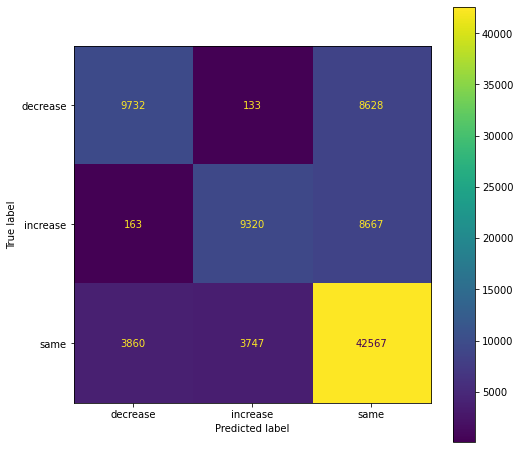

In [8]:
%%time
test_file = '2018'
test_data = 'data/yearly_tick_data/tab_'+ test_file +'.csv'

df1 = pd.read_csv(test_data)
df1.drop(remove_cols, axis=1, inplace=True)
x = df1.loc[:, df1.columns != target_col]
y = df1[target_col]

clf_xg = joblib.load('data/model/model_xg.pkl') 
predictions = clf_xg.predict(x)

df1['predictions'] = predictions
#df1.to_csv('data/'+file_name+'_2018_res.csv')

print(classification_report(y, predictions))

fig, ax = plt.subplots(figsize=(8, 8))
cm = confusion_matrix(y, predictions, labels=clf_xg.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf_xg.classes_)
disp.plot(ax=ax)

              precision    recall  f1-score   support

    decrease       0.70      0.50      0.58     22222
    increase       0.71      0.49      0.58     22656
        same       0.71      0.86      0.78     64322

    accuracy                           0.71    109200
   macro avg       0.71      0.62      0.65    109200
weighted avg       0.71      0.71      0.70    109200

Wall time: 4.01 s


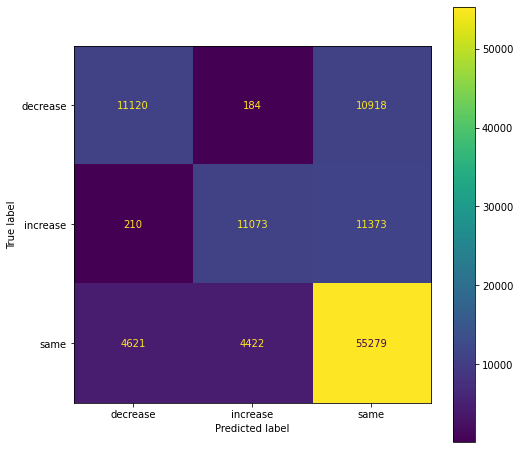

In [9]:
%%time
test_file = '2020'
test_data = 'data/yearly_tick_data/tab_'+ test_file +'.csv'

df1 = pd.read_csv(test_data)
df1.drop(remove_cols, axis=1, inplace=True)
x = df1.loc[:, df1.columns != target_col]
y = df1[target_col]

clf_xg = joblib.load('data/model/model_xg.pkl') 
predictions = clf_xg.predict(x)

df1['predictions'] = predictions
#df1.to_csv('data/'+file_name+'_2018_res.csv')

print(classification_report(y, predictions))

fig, ax = plt.subplots(figsize=(8, 8))
cm = confusion_matrix(y, predictions, labels=clf_xg.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf_xg.classes_)
disp.plot(ax=ax)

%%time
df1 = pd.read_csv('data/'+file_name+'_2017.csv')
df1.drop(remove_cols, axis=1, inplace=True)
x = df1.loc[:, df1.columns != target_col]
y = df1[target_col]

clf_xg = joblib.load('data/model/model_xg.pkl') 
predictions = clf_xg.predict(x)

df1['predictions'] = predictions
#df1.to_csv('data/'+file_name+'_2018_res.csv')

print(classification_report(y, predictions))

fig, ax = plt.subplots(figsize=(8, 8))
cm = confusion_matrix(y, predictions, labels=clf_xg.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf_xg.classes_)
disp.plot(ax=ax)

live_df = pd.read_csv('data/live_preds.csv')
live_df.drop(remove_cols, axis=1, inplace=True)
del live_df['predicted_direction']

scaler_obj = joblib.load('data/model/scaler_obj.pkl')
y_map = joblib.load('data/model/y_map.pkl') 
x_scaled = scaler_obj.transform(live_df.values)

predictions = clf_xg.predict(x_scaled)

live_df['predictions'] = [y_map[k] for k in predictions]

print(y_map)
live_df['predictions'].value_counts()

In [10]:
winsound.PlaySound('C:\\Windows\\Media\\tada.wav', winsound.SND_ASYNC)